In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import rasterio
from rasterio.enums import Resampling
import torch

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


1チャネルだけ読み込む使い方

(2568, 2800)


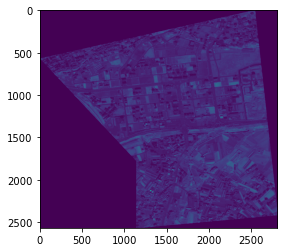

In [3]:
img1 = rasterio.open('./data/IMG_PHR1B_PMS_202011120200325_ORT_c1125b4d-6ced-4baf-cb8f-153c779e3dd0-001_R1C1.TIF')
data1 = img1.read(4)
# data1 = data1.transpose()
print(data1.shape)
img1 = np.array(data1)
plt.imshow(img1)

(2568, 2800)


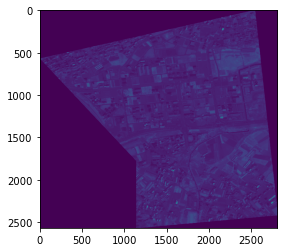

In [9]:
img2 = rasterio.open('./data/IMG_PHR1B_PMS_202103150203386_ORT_37003955-cf62-41c6-c131-17e8510c0e7d-001_R1C1.TIF')
data2 = img2.read(4)
# data2 = data2.transpose()
print(data2.shape)
img2 = np.array(data2)
plt.imshow(img2)

TIF画像の出力に必要な関数  
※ scale_percentileは機械学習を行う上での前処理用

In [37]:
# read the TIF image
def read_tif(img_name, data_dir):
    for file_name in os.listdir(data_dir):
        if file_name == img_name:
            psh = rasterio.open(data_dir + '/' + img_name)
            psh_meta = psh.meta
            psh = psh.read().transpose([1,2,0]).astype('float')
            return psh, psh_meta
            
# 4ch image -> rgb or grayscale
def stack_3band(img, i=1, j=2, k=4, gray=False):
    # (i,j,k) = (1,2,4) -> rgb
    img_3band = np.stack([img[:,:,i],
                    img[:,:,j],
                    img[:,:,k]], axis=2)
    img_gray = (img[:,:,i] + img[:,:,j] + img[:,:,k]) / 3
    if gray:
        return img_gray[:,:,np.newaxis].astype('int32')
    else:
        return img_3band

# scale the image and discard top 1 to visualize
# image processing for change detection using machine learning
def scale_percentile(matrix, percentile=1):
    w,h,d = matrix.shape
    matrix = np.reshape(matrix, [w*h,d]).astype(np.float64)
    # get 2nd and 98th percentile
    mins = np.percentile(matrix, percentile, axis=0)
    maxs = np.percentile(matrix, 100-percentile, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w,h,d])
    matrix = matrix.clip(0,1)
    return matrix

Text(0.5, 1.0, '20210315')

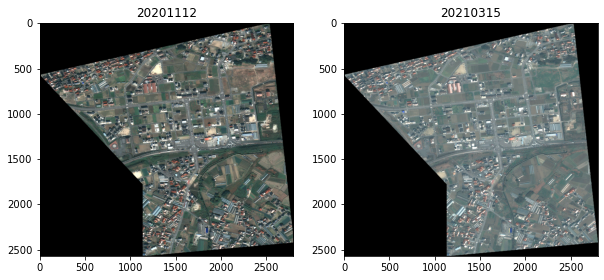

In [38]:
data_dir = './data'
tif1_name = 'IMG_PHR1B_PMS_202011120200325_ORT_c1125b4d-6ced-4baf-cb8f-153c779e3dd0-001_R1C1.TIF'
tif2_name = 'IMG_PHR1B_PMS_202103150203386_ORT_37003955-cf62-41c6-c131-17e8510c0e7d-001_R1C1.TIF'
psh1, psh1_meta = read_tif(tif1_name, data_dir)
psh2, psh2_meta = read_tif(tif2_name, data_dir)

# image check
psh_rgb1 = stack_3band(psh1, 0,1,2)
psh_rgb2 = stack_3band(psh2, 0,1,2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
ax1.imshow(scale_percentile(psh_rgb1))
ax1.set_title('20201112')
ax2.imshow(scale_percentile(psh_rgb2))
ax2.set_title('20210315')

In [15]:
print(psh_rgb1.shape)
print(psh1.shape)

(2568, 2800, 3)
(2568, 2800, 4)


In [20]:
x = [[10,20,30], [3,4,5]]
print(np.percentile(x, 50, axis=0))
print(np.percentile(x, 50, axis=1))

[ 6.5 12.  17.5]
[20.  4.]


必要な画像処理関数の定義

In [46]:
def ndi(img, i=7, j=4):
    # NDVI = (IR - R) / (IR + R) 
    # 画像によってどのスペクトルがIR, Rに対応しているかは異なる
    ndvi = (img[:,:,i] - img[:,:,j]) / (img[:,:,i] + img[:,:,j])
    return ndvi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, '20210315')

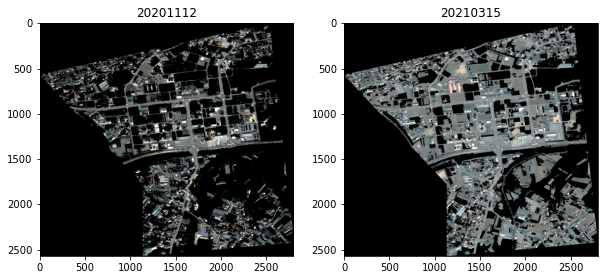

In [49]:
# NDVI thresholding
threshold = 0.3
psh1_copy = psh1.copy()
psh1_copy[ndi(psh1, 3, 2)>threshold] = 0 # この画像の場合は0基準で3: IR, 2: R
psh2_copy = psh2.copy()
psh2_copy[ndi(psh2, 3, 2)>threshold] = 0

# Image check
psh_rgb1 = stack_3band(psh1_copy, 0,1,2)
psh_rgb2 = stack_3band(psh2_copy, 0,1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(scale_percentile(psh_rgb1))
ax1.set_title('20201112')
ax2.imshow(scale_percentile(psh_rgb2))
ax2.set_title('20210315')

CVA, SAM

In [58]:
prev_img = psh1/65535
aft_img = psh2/65535
cv = prev_img.reshape([-1,4]) - aft_img.reshape([-1,4])
# print(cv.shape)
cva = np.linalg.norm(cv, ord=2, axis=1) # L2ノルムを計算
sam = np.array(prev_img.reshape([-1,4])*aft_img.reshape([-1,4])).sum(axis=1)/(np.sqrt(np.array(prev_img.reshape([-1,4])**2).sum(axis=1))*np.sqrt(np.array(aft_img.reshape([-1,4])**2).sum(axis=1)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


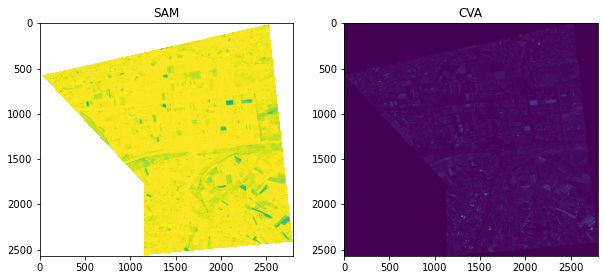

In [63]:
img_size = prev_img.shape[:2] # prev_img.shape = (2568,2800,4), prev_img.shape[:2] = (2568,2800)

# sam, cvaは1次元ベクトルにされているので, 2次元画像に復元
sam_2d = sam.reshape(img_size)
cva_2d = cva.reshape(img_size)

psh1_meta['count'] = 1 # ?

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
ax1.imshow(sam_2d)
ax1.set_title('SAM')
ax2.imshow(cva_2d)
ax2.set_title('CVA')

# ファイル書き込み
sam_2d_int16 = 65535*sam_2d[np.newaxis,:,:]
with rasterio.open('sam_2d.tif', 'w', **psh1_meta) as dst:
    dst.write(sam_2d_int16.astype(rasterio.uint16))

PCA

In [66]:
from sklearn.decomposition import PCA
import cv2
from sklearn.cluster import KMeans
from collections import Counter

# 必要な関数
def count_set(diff_image, img_size):
    count = 0
    for i in range(int(img_size[0]/rect_size)):
        for j in range(int(img_size[1]/rect_size)):
            block = diff_image[i*rect_size:(i + 1)*rect_size, 
                                 j*rect_size:(j + 1)*rect_size]
            if np.any(block==0): # block内に0という要素が1つでもあればcontinue
                continue
            count+=1
    return count

def find_vector_set(diff_image, img_size):
    block_count = count_set(diff_image, img_size)
    vector_set = np.zeros((block_count, rect_size**2))
    k = 0
    for i in range(int(img_size[0]/rect_size)):
        for j in range(int(img_size[1]/rect_size)):
            block = diff_image[i*rect_size:(i+1)*rect_size,
                              j*rect_size:(j+1)*rect_size]
            if np.any(block==0): # block内に0という要素が1つでもあればcontinue
                continue
            feature = block.ravel() # blockを1次元リストに整形して返却
            vector_set[k,:] = feature
            k += 1
    mean_vec = np.mean(vector_set, axis=0)
    vector_set = vector_set - mean_vec
    return vector_set, mean_vec

def find_FVS(EVS, diff_image, mean_vec, img_size):
    i = int(rect_size/2)
    feature_vector_set = []
    
    while i < img_size[0] - int(rect_size/2):
        j = int(rect_size/2)
        while j < img_size[1] - int(rect_size/2):
            block = diff_image[i-int(rect_size/2):i+int(rect_size/2)+1,
                              j-int(rect_size/2):j+int(rect_size/2)+1]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j + 1
        i = i + 1
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("\nfeature vector space size", FVS.shape)
    return FVS

def clustering(FVS, components, img_size):
    kmeans = KMeans(components, verbose=0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count = Counter(output)
    least_index = min(count, key = count.get)
    change_map = np.reshape(output, (img_size[0]-rect_size+1,
                                    img_size[1]-rect_size+1))
    return least_index, change_map

In [67]:
rect_size = 3

diff_img = abs(psh1-psh2)
img_size = diff_img.shape
change_list = np.zeros((img_size[0] - rect_size + 1, img_size[1] - rect_size + 1, 4))
for i in range(diff_img.shape[2]):
    diff_image_band = diff_img[:,:,i]
    vector_set, mean_vec = find_vector_set(diff_image_band, img_size)
    pca = PCA()
    pca.fit(vector_set)
    EVS = pca.components_
    
    FVS = find_FVS(EVS, diff_image_band, mean_vec, img_size)
    components = 5
    least_index, change_map = clustering(FVS, components, img_size)
    
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_list[:,:,i] = change_map


feature vector space size (7179668, 9)

feature vector space size (7179668, 9)

feature vector space size (7179668, 9)

feature vector space size (7179668, 9)


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


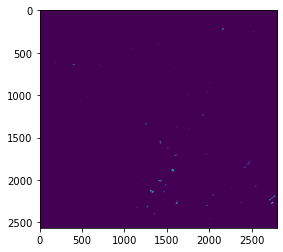

In [72]:
change_add = change_list.reshape(-1,4).sum(axis=1).reshape(img_size[0] - rect_size + 1, 
                                                          img_size[1] - rect_size + 1)
change_map[change_add > 255*3] = 255
change_map[change_add <= 255*2] = 0

kernel = np.asarray(((0,0,1,0,0),
                         (0,1,1,1,0),
                         (1,1,1,1,1),
                         (0,1,1,1,0),
                         (0,0,1,0,0)), dtype=np.uint8) # np.arrayと異なり, 元のリストと同期して変化する（バックアップ用のコピーにはならない）
change_map = change_map.astype(np.uint8)
clean_change_map = cv2.erode(change_map, kernel)
plt.imshow(change_map)

change_map_int16 = 65536*change_map[np.newaxis,:,:]
psh1_meta = psh1_meta.copy()
psh1_meta['height'] = change_map.shape[1]
psh1_meta['width'] = change_map.shape[0]
with rasterio.open('pca_2d.tif', 'w', **psh1_meta) as dst:
    dst.write(change_map_int16.astype(rasterio.uint16))

ModuleNotFoundError: No module named 'albumentations'